In [2]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob
import molvs
from multiprocessing import Pool, cpu_count
from tqdm.auto import tqdm

In [3]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/three_proteins/5l7i
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/three_proteins


Reading data from crossdock dataset, add a standardization for small molecule data:

In [4]:
standardizer = molvs.standardize.Standardizer()

def standardize_mol(mol):
    try:
        mol = standardizer.standardize(mol)
        mol = standardizer.fragment_parent(mol, skip_standardize=True)
        mol = standardizer.tautomer_parent(mol, skip_standardize=True)
        mol = standardizer.isotope_parent(mol, skip_standardize=True)
        mol = standardizer.charge_parent(mol, skip_standardize=True)
        return mol
    except:
        return None

In [6]:
smi_list = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/three_proteins/5l7i/5l7i_top500_smiles_cpu.smi') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in tqdm(smi_list, desc="Standardizing molecules", unit="mol"):
    mol = Chem.MolFromSmiles(smi)
    mol = standardize_mol(mol)
    
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))
    else:
        print(f"Skipping molecule {smi}")
        pass

print(len(smi_list))
len(standardized_smiles_list)

Standardizing molecules:   0%|          | 0/500 [00:00<?, ?mol/s]

500


500

Set the default image size

In [7]:
with open('5l7i_top500_smiles_standardized_cpu.smi', 'w') as f:
    for item in standardized_smiles_list:
        f.write("%s\n" % item)

In [8]:
uru.rd_set_image_size(300,300)

Convert SMILES and name of them to a dataframe

In [9]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

,SMILES
0,O=C(N=c1cc(-c2ccn(Cc3ccccc3)n2)[nH][nH]1)c1ccc...
1,O=C(Nc1ccccc1Cc1ccccc1)C(=O)N1CCC(c2c[nH]c3ncc...
2,Cc1ccc(Oc2cc(-c3noc(-c4n[nH]c(=O)c5ccccc45)n3)...
3,Cc1cccc(-c2nnc3n2CC(C(=O)N=c2[nH][nH]c4[nH]c(=...
4,CN1CCN(Cc2cccc(C(=O)N3CCC(c4c(O)[nH]c5ccccc45)...
...,...
495,O=C1Nc2ccc(S(=O)(=O)N=c3cc(-c4cccc(F)c4F)[nH][...
496,Cc1cc(C(F)(F)F)ccc1C(=O)N1CCN(C(=O)c2ccc(F)c(F...
497,O=C(CN1C(=O)N[C@]2(CCc3ccccc32)C1=O)N1CCN(C(=O...
498,O=C(C1CCN(S(=O)(=O)c2ccc3c(c2)CCC3)CC1)N1CCCC1...


Remove repeated molecules

In [10]:
df = df.drop_duplicates(['SMILES'])
df.reset_index(inplace=True, drop=True)
df

,SMILES
0,O=C(N=c1cc(-c2ccn(Cc3ccccc3)n2)[nH][nH]1)c1ccc...
1,O=C(Nc1ccccc1Cc1ccccc1)C(=O)N1CCC(c2c[nH]c3ncc...
2,Cc1ccc(Oc2cc(-c3noc(-c4n[nH]c(=O)c5ccccc45)n3)...
3,Cc1cccc(-c2nnc3n2CC(C(=O)N=c2[nH][nH]c4[nH]c(=...
4,CN1CCN(Cc2cccc(C(=O)N3CCC(c4c(O)[nH]c5ccccc45)...
...,...
495,O=C1Nc2ccc(S(=O)(=O)N=c3cc(-c4cccc(F)c4F)[nH][...
496,Cc1cc(C(F)(F)F)ccc1C(=O)N1CCN(C(=O)c2ccc(F)c(F...
497,O=C(CN1C(=O)N[C@]2(CCc3ccccc32)C1=O)N1CCN(C(=O...
498,O=C(C1CCN(S(=O)(=O)c2ccc3c(c2)CCC3)CC1)N1CCCC1...


Save the smi file for further use

In [11]:
smi_export_list = df['SMILES'].tolist()
with open('crossdock_ligand_smi.smi', 'w') as f:
    for item in smi_export_list:
        f.write("%s\n" % item)

Add an RDKit molecule to the dataframe

In [12]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

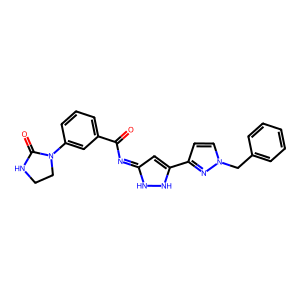

In [13]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [14]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0      [N=c1cc[nH][nH]1, c1cn[nH]c1, c1ccccc1, c1cccc...
1       [c1ccccc1, c1ccccc1, C1CCNCC1, c1cnc2[nH]ccc2c1]
2      [c1ccccc1, c1ccncc1, c1ncon1, O=c1[nH]ncc2cccc...
3      [c1ccccc1, c1nnc2n1CCCC2, N=c1[nH][nH]c2[nH]c(...
4       [C1CNCCN1, c1ccccc1, C1CCNCC1, c1ccc2[nH]ccc2c1]
                             ...                        
495    [O=C1Nc2cccc3cccc1c23, N=c1cc[nH][nH]1, c1ccccc1]
496                       [c1ccccc1, C1CNCCN1, c1ccccc1]
497    [O=C1NC(=O)[C@@]2(CCc3ccccc32)N1, C1CNCCN1, c1...
498    [C1CCNCC1, c1ccc2c(c1)CCC2, C1CCNC1, c1ccn2cnn...
499                 [c1ccccc1, C1CCNCC1, c1ccc2ccccc2c1]
Name: ring_sytems, Length: 500, dtype: object

In [15]:
df.ring_sytems.values

array([list(['N=c1cc[nH][nH]1', 'c1cn[nH]c1', 'c1ccccc1', 'c1ccccc1', 'O=C1NCCN1']),
       list(['c1ccccc1', 'c1ccccc1', 'C1CCNCC1', 'c1cnc2[nH]ccc2c1']),
       list(['c1ccccc1', 'c1ccncc1', 'c1ncon1', 'O=c1[nH]ncc2ccccc12']),
       list(['c1ccccc1', 'c1nnc2n1CCCC2', 'N=c1[nH][nH]c2[nH]c(=O)ccc12']),
       list(['C1CNCCN1', 'c1ccccc1', 'C1CCNCC1', 'c1ccc2[nH]ccc2c1']),
       list(['O=C1CNc2ccccc2N1', 'c1ccccc1', 'c1n[nH]c2c1CCC2', 'c1ccccc1']),
       list(['c1ccc2c(c1)ccc1ccoc12', 'O=C1COc2ccccc2N1']),
       list(['c1nc[nH]n1', 'c1ccccc1', 'c1ncon1', 'O=C1CCCN1', 'c1ccccc1']),
       list(['c1ccccc1', 'O=C1NC(=O)c2ccccc21', 'C1CNC1', 'c1ccc2ncccc2c1']),
       list(['c1ccc2[nH]ccc2c1', 'c1ccccc1', 'c1ccc2[nH]ccc2c1']),
       list(['C1[C@H]2[C@H]3C[C@H]4[C@@H]1[C@H]1[C@@H]2C[C@@H]3[C@@H]41', 'C1CC1', 'c1ccc2ccccc2c1']),
       list(['c1ccoc1', 'c1ccccc1', 'C1CNCCN1', 'c1ccc2c(c1)OCCO2']),
       list(['c1ccncc1', 'c1ccccc1', 'C1CCNCC1', 'c1ccccc1']),
       list(['N=c1nccc[nH]1'

See how many times each ring system occurs

In [16]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

,SMILES,Count
2,c1ccccc1,597
4,C1CCNCC1,103
24,c1ccc2ccccc2c1,55
11,C1CNCCN1,49
7,c1ncon1,34
...,...,...
140,C=C1N=COC1=O,1
143,c1[nH]cc2c1[C@@H]1CC[C@H]2O1,1
42,O=C1CCCc2[nH]ccc21,1
47,O=c1cc[nH]c2ccnn12,1


View the ring system frequencies

In [17]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [18]:
ring_system_lookup = uru.RingSystemLookup()
res = df.mol.apply(ring_system_lookup.process_mol)

In [19]:
res

0      [(N=c1cc[nH][nH]1, 77), (c1cn[nH]c1, 112133), ...
1      [(c1ccccc1, 2568039), (c1ccccc1, 2568039), (C1...
2      [(c1ccccc1, 2568039), (c1ccncc1, 275595), (c1n...
3      [(c1ccccc1, 2568039), (c1nnc2n1CCCC2, 320), (N...
4      [(C1CNCCN1, 161505), (c1ccccc1, 2568039), (C1C...
                             ...                        
495    [(O=C1Nc2cccc3cccc1c23, 595), (N=c1cc[nH][nH]1...
496    [(c1ccccc1, 2568039), (C1CNCCN1, 161505), (c1c...
497    [(O=C1NC(=O)[C@@]2(CCc3ccccc32)N1, 27), (C1CNC...
498    [(C1CCNCC1, 212367), (c1ccc2c(c1)CCC2, 10459),...
499    [(c1ccccc1, 2568039), (C1CCNCC1, 212367), (c1c...
Name: mol, Length: 500, dtype: object

In [20]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq
0,O=C(N=c1cc(-c2ccn(Cc3ccccc3)n2)[nH][nH]1)c1ccc...,<rdkit.Chem.rdchem.Mol object at 0x745d40760820>,"[N=c1cc[nH][nH]1, c1cn[nH]c1, c1ccccc1, c1cccc...",N=c1cc[nH][nH]1,77
1,O=C(Nc1ccccc1Cc1ccccc1)C(=O)N1CCC(c2c[nH]c3ncc...,<rdkit.Chem.rdchem.Mol object at 0x745d407610e0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1cnc2[nH]ccc2c1]",c1cnc2[nH]ccc2c1,7932
2,Cc1ccc(Oc2cc(-c3noc(-c4n[nH]c(=O)c5ccccc45)n3)...,<rdkit.Chem.rdchem.Mol object at 0x745d40762030>,"[c1ccccc1, c1ccncc1, c1ncon1, O=c1[nH]ncc2cccc...",O=c1[nH]ncc2ccccc12,3852
3,Cc1cccc(-c2nnc3n2CC(C(=O)N=c2[nH][nH]c4[nH]c(=...,<rdkit.Chem.rdchem.Mol object at 0x745d40763bc0>,"[c1ccccc1, c1nnc2n1CCCC2, N=c1[nH][nH]c2[nH]c(...",N=c1[nH][nH]c2[nH]c(=O)ccc12,0
4,CN1CCN(Cc2cccc(C(=O)N3CCC(c4c(O)[nH]c5ccccc45)...,<rdkit.Chem.rdchem.Mol object at 0x745d40761fc0>,"[C1CNCCN1, c1ccccc1, C1CCNCC1, c1ccc2[nH]ccc2c1]",c1ccc2[nH]ccc2c1,108866
...,...,...,...,...,...
495,O=C1Nc2ccc(S(=O)(=O)N=c3cc(-c4cccc(F)c4F)[nH][...,<rdkit.Chem.rdchem.Mol object at 0x745d40172e30>,"[O=C1Nc2cccc3cccc1c23, N=c1cc[nH][nH]1, c1ccccc1]",N=c1cc[nH][nH]1,77
496,Cc1cc(C(F)(F)F)ccc1C(=O)N1CCN(C(=O)c2ccc(F)c(F...,<rdkit.Chem.rdchem.Mol object at 0x745d401731b0>,"[c1ccccc1, C1CNCCN1, c1ccccc1]",C1CNCCN1,161505
497,O=C(CN1C(=O)N[C@]2(CCc3ccccc32)C1=O)N1CCN(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x745d40173a70>,"[O=C1NC(=O)[C@@]2(CCc3ccccc32)N1, C1CNCCN1, c1...",O=C1NC(=O)[C@@]2(CCc3ccccc32)N1,27
498,O=C(C1CCN(S(=O)(=O)c2ccc3c(c2)CCC3)CC1)N1CCCC1...,<rdkit.Chem.rdchem.Mol object at 0x745d40173370>,"[C1CCNCC1, c1ccc2c(c1)CCC2, C1CCNC1, c1ccn2cnn...",c1ccn2cnnc2c1,2753


In [21]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [22]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[13:19:20] WARNING: Omitted undefined stereo

[13:19:20] WARNING: Omitted undefined stereo

[13:19:20] WARNING: Omitted undefined stereo

[13:19:20] WARNING: Omitted undefined stereo

[13:19:20] WARNING: Omitted undefined stereo

[13:19:20] WARNING: Omitted undefined stereo

[13:19:20] WARNING: Omitted undefined stereo

[13:19:20] WARNING: Omitted undefined stereo

[13:19:20] WARNING: Omitted undefined stereo

[13:19:20] WARNING: Omitted undefined stereo

[13:19:20] WARNING: Omitted undefined stereo

[13:19:20] WARNING: Omitted undefined stereo

[13:19:20] WARNING: Omitted undefined stereo

[13:19:20] WARNING: Omitted undefined stereo

[13:19:20] WARNING: Omitted undefined stereo

[13:19:20] WARNING: Omitted undefined stereo

[13:19:20] WARNING: Omitted undefined stereo

[13:19:20] WARNING: Omitted undefined stereo

[13:19:20] WARNING: Omitted undefined stereo

[13:19:20] WARNING: Omitted undefined stereo

[13:19:20] WARNING: Omitted undefined stereo

[13:19:20] WARNING: Omitted undefi

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,O=C(N=c1cc(-c2ccn(Cc3ccccc3)n2)[nH][nH]1)c1ccc...,<rdkit.Chem.rdchem.Mol object at 0x745d40760820>,"[N=c1cc[nH][nH]1, c1cn[nH]c1, c1ccccc1, c1cccc...",N=c1cc[nH][nH]1,77,InChI=1S/C23H21N7O2/c31-22(17-7-4-8-18(13-17)3...
1,O=C(Nc1ccccc1Cc1ccccc1)C(=O)N1CCC(c2c[nH]c3ncc...,<rdkit.Chem.rdchem.Mol object at 0x745d407610e0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1cnc2[nH]ccc2c1]",c1cnc2[nH]ccc2c1,7932,InChI=1S/C27H26N4O2/c32-26(30-24-11-5-4-9-21(2...
2,Cc1ccc(Oc2cc(-c3noc(-c4n[nH]c(=O)c5ccccc45)n3)...,<rdkit.Chem.rdchem.Mol object at 0x745d40762030>,"[c1ccccc1, c1ccncc1, c1ncon1, O=c1[nH]ncc2cccc...",O=c1[nH]ncc2ccccc12,3852,InChI=1S/C23H17N5O3/c1-13-7-8-16(11-14(13)2)30...
3,Cc1cccc(-c2nnc3n2CC(C(=O)N=c2[nH][nH]c4[nH]c(=...,<rdkit.Chem.rdchem.Mol object at 0x745d40763bc0>,"[c1ccccc1, c1nnc2n1CCCC2, N=c1[nH][nH]c2[nH]c(...",N=c1[nH][nH]c2[nH]c(=O)ccc12,0,InChI=1S/C20H19N7O2/c1-11-3-2-4-12(9-11)19-26-...
4,CN1CCN(Cc2cccc(C(=O)N3CCC(c4c(O)[nH]c5ccccc45)...,<rdkit.Chem.rdchem.Mol object at 0x745d40761fc0>,"[C1CNCCN1, c1ccccc1, C1CCNCC1, c1ccc2[nH]ccc2c1]",c1ccc2[nH]ccc2c1,108866,InChI=1S/C26H32N4O2/c1-28-13-15-29(16-14-28)18...
...,...,...,...,...,...,...
495,O=C1Nc2ccc(S(=O)(=O)N=c3cc(-c4cccc(F)c4F)[nH][...,<rdkit.Chem.rdchem.Mol object at 0x745d40172e30>,"[O=C1Nc2cccc3cccc1c23, N=c1cc[nH][nH]1, c1ccccc1]",N=c1cc[nH][nH]1,77,InChI=1S/C20H12F2N4O3S/c21-13-6-2-3-10(19(13)2...
496,Cc1cc(C(F)(F)F)ccc1C(=O)N1CCN(C(=O)c2ccc(F)c(F...,<rdkit.Chem.rdchem.Mol object at 0x745d401731b0>,"[c1ccccc1, C1CNCCN1, c1ccccc1]",C1CNCCN1,161505,"InChI=1S/C20H17F5N2O2/c1-12-10-14(20(23,24)25)..."
497,O=C(CN1C(=O)N[C@]2(CCc3ccccc32)C1=O)N1CCN(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x745d40173a70>,"[O=C1NC(=O)[C@@]2(CCc3ccccc32)N1, C1CNCCN1, c1...",O=C1NC(=O)[C@@]2(CCc3ccccc32)N1,27,InChI=1S/C26H26N4O6/c31-22(15-30-24(33)26(27-2...
498,O=C(C1CCN(S(=O)(=O)c2ccc3c(c2)CCC3)CC1)N1CCCC1...,<rdkit.Chem.rdchem.Mol object at 0x745d40173370>,"[C1CCNCC1, c1ccc2c(c1)CCC2, C1CCNC1, c1ccn2cnn...",c1ccn2cnnc2c1,2753,InChI=1S/C25H29N5O3S/c31-25(29-14-4-7-22(29)24...


How many of them have ring system?

In [23]:
df_ring = df[df.min_freq != -1]
df_ring

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,O=C(N=c1cc(-c2ccn(Cc3ccccc3)n2)[nH][nH]1)c1ccc...,<rdkit.Chem.rdchem.Mol object at 0x745d40760820>,"[N=c1cc[nH][nH]1, c1cn[nH]c1, c1ccccc1, c1cccc...",N=c1cc[nH][nH]1,77,InChI=1S/C23H21N7O2/c31-22(17-7-4-8-18(13-17)3...
1,O=C(Nc1ccccc1Cc1ccccc1)C(=O)N1CCC(c2c[nH]c3ncc...,<rdkit.Chem.rdchem.Mol object at 0x745d407610e0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1cnc2[nH]ccc2c1]",c1cnc2[nH]ccc2c1,7932,InChI=1S/C27H26N4O2/c32-26(30-24-11-5-4-9-21(2...
2,Cc1ccc(Oc2cc(-c3noc(-c4n[nH]c(=O)c5ccccc45)n3)...,<rdkit.Chem.rdchem.Mol object at 0x745d40762030>,"[c1ccccc1, c1ccncc1, c1ncon1, O=c1[nH]ncc2cccc...",O=c1[nH]ncc2ccccc12,3852,InChI=1S/C23H17N5O3/c1-13-7-8-16(11-14(13)2)30...
3,Cc1cccc(-c2nnc3n2CC(C(=O)N=c2[nH][nH]c4[nH]c(=...,<rdkit.Chem.rdchem.Mol object at 0x745d40763bc0>,"[c1ccccc1, c1nnc2n1CCCC2, N=c1[nH][nH]c2[nH]c(...",N=c1[nH][nH]c2[nH]c(=O)ccc12,0,InChI=1S/C20H19N7O2/c1-11-3-2-4-12(9-11)19-26-...
4,CN1CCN(Cc2cccc(C(=O)N3CCC(c4c(O)[nH]c5ccccc45)...,<rdkit.Chem.rdchem.Mol object at 0x745d40761fc0>,"[C1CNCCN1, c1ccccc1, C1CCNCC1, c1ccc2[nH]ccc2c1]",c1ccc2[nH]ccc2c1,108866,InChI=1S/C26H32N4O2/c1-28-13-15-29(16-14-28)18...
...,...,...,...,...,...,...
495,O=C1Nc2ccc(S(=O)(=O)N=c3cc(-c4cccc(F)c4F)[nH][...,<rdkit.Chem.rdchem.Mol object at 0x745d40172e30>,"[O=C1Nc2cccc3cccc1c23, N=c1cc[nH][nH]1, c1ccccc1]",N=c1cc[nH][nH]1,77,InChI=1S/C20H12F2N4O3S/c21-13-6-2-3-10(19(13)2...
496,Cc1cc(C(F)(F)F)ccc1C(=O)N1CCN(C(=O)c2ccc(F)c(F...,<rdkit.Chem.rdchem.Mol object at 0x745d401731b0>,"[c1ccccc1, C1CNCCN1, c1ccccc1]",C1CNCCN1,161505,"InChI=1S/C20H17F5N2O2/c1-12-10-14(20(23,24)25)..."
497,O=C(CN1C(=O)N[C@]2(CCc3ccccc32)C1=O)N1CCN(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x745d40173a70>,"[O=C1NC(=O)[C@@]2(CCc3ccccc32)N1, C1CNCCN1, c1...",O=C1NC(=O)[C@@]2(CCc3ccccc32)N1,27,InChI=1S/C26H26N4O6/c31-22(15-30-24(33)26(27-2...
498,O=C(C1CCN(S(=O)(=O)c2ccc3c(c2)CCC3)CC1)N1CCCC1...,<rdkit.Chem.rdchem.Mol object at 0x745d40173370>,"[C1CCNCC1, c1ccc2c(c1)CCC2, C1CCNC1, c1ccn2cnn...",c1ccn2cnnc2c1,2753,InChI=1S/C25H29N5O3S/c31-25(29-14-4-7-22(29)24...


In [24]:
filtered_df_ring_freq = df[df.min_freq > 100]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
1,O=C(Nc1ccccc1Cc1ccccc1)C(=O)N1CCC(c2c[nH]c3ncc...,<rdkit.Chem.rdchem.Mol object at 0x745d407610e0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1cnc2[nH]ccc2c1]",c1cnc2[nH]ccc2c1,7932,InChI=1S/C27H26N4O2/c32-26(30-24-11-5-4-9-21(2...
2,Cc1ccc(Oc2cc(-c3noc(-c4n[nH]c(=O)c5ccccc45)n3)...,<rdkit.Chem.rdchem.Mol object at 0x745d40762030>,"[c1ccccc1, c1ccncc1, c1ncon1, O=c1[nH]ncc2cccc...",O=c1[nH]ncc2ccccc12,3852,InChI=1S/C23H17N5O3/c1-13-7-8-16(11-14(13)2)30...
4,CN1CCN(Cc2cccc(C(=O)N3CCC(c4c(O)[nH]c5ccccc45)...,<rdkit.Chem.rdchem.Mol object at 0x745d40761fc0>,"[C1CNCCN1, c1ccccc1, C1CCNCC1, c1ccc2[nH]ccc2c1]",c1ccc2[nH]ccc2c1,108866,InChI=1S/C26H32N4O2/c1-28-13-15-29(16-14-28)18...
5,O=C1CN(C(=O)c2ccc(NC(=O)c3nn(-c4ccccc4)c4c3CCC...,<rdkit.Chem.rdchem.Mol object at 0x745d407604a0>,"[O=C1CNc2ccccc2N1, c1ccccc1, c1n[nH]c2c1CCC2, ...",c1n[nH]c2c1CCC2,515,InChI=1S/C28H23N5O3/c34-25-17-32(24-11-5-4-10-...
6,Cc1c(C(=O)Nc2ccc3c(c2)NC(=O)C(C)O3)oc2c1ccc1cc...,<rdkit.Chem.rdchem.Mol object at 0x745d40761d20>,"[c1ccc2c(c1)ccc1ccoc12, O=C1COc2ccccc2N1]",c1ccc2c(c1)ccc1ccoc12,107,InChI=1S/C23H18N2O4/c1-12-16-9-7-14-5-3-4-6-17...
...,...,...,...,...,...,...
493,O=C(C[C@@H]1CC=CCC1)N1C[C@@H]2C[C@H]1CN2C(=O)c...,<rdkit.Chem.rdchem.Mol object at 0x745d40173c30>,"[C1=CCCCC1, C1N[C@@H]2CN[C@H]1C2, c1ccc2c3c([n...",c1ccc2c3c([nH]c2c1)CCC3,153,InChI=1S/C25H29N3O2/c29-23(12-16-6-2-1-3-7-16)...
494,CN1C(=O)c2ccc(C(=O)N3CCN(C(=O)c4ccccc4F)CC3)cc...,<rdkit.Chem.rdchem.Mol object at 0x745d401738b0>,"[O=C1NC(=O)c2ccccc21, C1CNCCN1, c1ccccc1]",O=C1NC(=O)c2ccccc21,10649,InChI=1S/C21H18FN3O4/c1-23-19(27)14-7-6-13(12-...
496,Cc1cc(C(F)(F)F)ccc1C(=O)N1CCN(C(=O)c2ccc(F)c(F...,<rdkit.Chem.rdchem.Mol object at 0x745d401731b0>,"[c1ccccc1, C1CNCCN1, c1ccccc1]",C1CNCCN1,161505,"InChI=1S/C20H17F5N2O2/c1-12-10-14(20(23,24)25)..."
498,O=C(C1CCN(S(=O)(=O)c2ccc3c(c2)CCC3)CC1)N1CCCC1...,<rdkit.Chem.rdchem.Mol object at 0x745d40173370>,"[C1CCNCC1, c1ccc2c(c1)CCC2, C1CCNC1, c1ccn2cnn...",c1ccn2cnnc2c1,2753,InChI=1S/C25H29N5O3S/c31-25(29-14-4-7-22(29)24...


### How many of them could pass PAINS filter?

Get a list of rules

In [25]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [26]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [27]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [28]:
reos.pandas_mols(df.mol)

  0%|          | 0/500 [00:00<?, ?it/s]

,rule_set_name,description
0,ok,ok
1,ok,ok
2,ok,ok
3,ok,ok
4,ok,ok
...,...,...
495,ok,ok
496,ok,ok
497,ok,ok
498,ok,ok


In [29]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/500 [00:00<?, ?it/s]

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,rule_set_name,description
0,O=C(N=c1cc(-c2ccn(Cc3ccccc3)n2)[nH][nH]1)c1ccc...,<rdkit.Chem.rdchem.Mol object at 0x745d40760820>,"[N=c1cc[nH][nH]1, c1cn[nH]c1, c1ccccc1, c1cccc...",N=c1cc[nH][nH]1,77,InChI=1S/C23H21N7O2/c31-22(17-7-4-8-18(13-17)3...,ok,ok
1,O=C(Nc1ccccc1Cc1ccccc1)C(=O)N1CCC(c2c[nH]c3ncc...,<rdkit.Chem.rdchem.Mol object at 0x745d407610e0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1cnc2[nH]ccc2c1]",c1cnc2[nH]ccc2c1,7932,InChI=1S/C27H26N4O2/c32-26(30-24-11-5-4-9-21(2...,ok,ok
2,Cc1ccc(Oc2cc(-c3noc(-c4n[nH]c(=O)c5ccccc45)n3)...,<rdkit.Chem.rdchem.Mol object at 0x745d40762030>,"[c1ccccc1, c1ccncc1, c1ncon1, O=c1[nH]ncc2cccc...",O=c1[nH]ncc2ccccc12,3852,InChI=1S/C23H17N5O3/c1-13-7-8-16(11-14(13)2)30...,ok,ok
3,Cc1cccc(-c2nnc3n2CC(C(=O)N=c2[nH][nH]c4[nH]c(=...,<rdkit.Chem.rdchem.Mol object at 0x745d40763bc0>,"[c1ccccc1, c1nnc2n1CCCC2, N=c1[nH][nH]c2[nH]c(...",N=c1[nH][nH]c2[nH]c(=O)ccc12,0,InChI=1S/C20H19N7O2/c1-11-3-2-4-12(9-11)19-26-...,ok,ok
4,CN1CCN(Cc2cccc(C(=O)N3CCC(c4c(O)[nH]c5ccccc45)...,<rdkit.Chem.rdchem.Mol object at 0x745d40761fc0>,"[C1CNCCN1, c1ccccc1, C1CCNCC1, c1ccc2[nH]ccc2c1]",c1ccc2[nH]ccc2c1,108866,InChI=1S/C26H32N4O2/c1-28-13-15-29(16-14-28)18...,ok,ok
...,...,...,...,...,...,...,...,...
495,O=C1Nc2ccc(S(=O)(=O)N=c3cc(-c4cccc(F)c4F)[nH][...,<rdkit.Chem.rdchem.Mol object at 0x745d40172e30>,"[O=C1Nc2cccc3cccc1c23, N=c1cc[nH][nH]1, c1ccccc1]",N=c1cc[nH][nH]1,77,InChI=1S/C20H12F2N4O3S/c21-13-6-2-3-10(19(13)2...,ok,ok
496,Cc1cc(C(F)(F)F)ccc1C(=O)N1CCN(C(=O)c2ccc(F)c(F...,<rdkit.Chem.rdchem.Mol object at 0x745d401731b0>,"[c1ccccc1, C1CNCCN1, c1ccccc1]",C1CNCCN1,161505,"InChI=1S/C20H17F5N2O2/c1-12-10-14(20(23,24)25)...",ok,ok
497,O=C(CN1C(=O)N[C@]2(CCc3ccccc32)C1=O)N1CCN(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x745d40173a70>,"[O=C1NC(=O)[C@@]2(CCc3ccccc32)N1, C1CNCCN1, c1...",O=C1NC(=O)[C@@]2(CCc3ccccc32)N1,27,InChI=1S/C26H26N4O6/c31-22(15-30-24(33)26(27-2...,ok,ok
498,O=C(C1CCN(S(=O)(=O)c2ccc3c(c2)CCC3)CC1)N1CCCC1...,<rdkit.Chem.rdchem.Mol object at 0x745d40173370>,"[C1CCNCC1, c1ccc2c(c1)CCC2, C1CCNC1, c1ccn2cnn...",c1ccn2cnnc2c1,2753,InChI=1S/C25H29N5O3S/c31-25(29-14-4-7-22(29)24...,ok,ok


Test all filters from rd filters

In [30]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/500 [00:00<?, ?it/s]

Glaxo 0.97 ['Glaxo'] 485


  0%|          | 0/500 [00:00<?, ?it/s]

Dundee 0.796 ['Dundee'] 398


  0%|          | 0/500 [00:00<?, ?it/s]

BMS 0.956 ['BMS'] 478


  0%|          | 0/500 [00:00<?, ?it/s]

SureChEMBL 0.984 ['SureChEMBL'] 492


  0%|          | 0/500 [00:00<?, ?it/s]

MLSMR 0.696 ['MLSMR'] 348


  0%|          | 0/500 [00:00<?, ?it/s]

Inpharmatica 0.898 ['Inpharmatica'] 449


  0%|          | 0/500 [00:00<?, ?it/s]

LINT 0.84 ['LINT'] 420


### How many of them could pass filters suggested by Dr.Reymond?

In [31]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,O=C(N=c1cc(-c2ccn(Cc3ccccc3)n2)[nH][nH]1)c1ccc...,<rdkit.Chem.rdchem.Mol object at 0x745d40760820>,"[N=c1cc[nH][nH]1, c1cn[nH]c1, c1ccccc1, c1cccc...",N=c1cc[nH][nH]1,77,InChI=1S/C23H21N7O2/c31-22(17-7-4-8-18(13-17)3...,True
1,O=C(Nc1ccccc1Cc1ccccc1)C(=O)N1CCC(c2c[nH]c3ncc...,<rdkit.Chem.rdchem.Mol object at 0x745d407610e0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1cnc2[nH]ccc2c1]",c1cnc2[nH]ccc2c1,7932,InChI=1S/C27H26N4O2/c32-26(30-24-11-5-4-9-21(2...,True
2,Cc1ccc(Oc2cc(-c3noc(-c4n[nH]c(=O)c5ccccc45)n3)...,<rdkit.Chem.rdchem.Mol object at 0x745d40762030>,"[c1ccccc1, c1ccncc1, c1ncon1, O=c1[nH]ncc2cccc...",O=c1[nH]ncc2ccccc12,3852,InChI=1S/C23H17N5O3/c1-13-7-8-16(11-14(13)2)30...,True
3,Cc1cccc(-c2nnc3n2CC(C(=O)N=c2[nH][nH]c4[nH]c(=...,<rdkit.Chem.rdchem.Mol object at 0x745d40763bc0>,"[c1ccccc1, c1nnc2n1CCCC2, N=c1[nH][nH]c2[nH]c(...",N=c1[nH][nH]c2[nH]c(=O)ccc12,0,InChI=1S/C20H19N7O2/c1-11-3-2-4-12(9-11)19-26-...,True
4,CN1CCN(Cc2cccc(C(=O)N3CCC(c4c(O)[nH]c5ccccc45)...,<rdkit.Chem.rdchem.Mol object at 0x745d40761fc0>,"[C1CNCCN1, c1ccccc1, C1CCNCC1, c1ccc2[nH]ccc2c1]",c1ccc2[nH]ccc2c1,108866,InChI=1S/C26H32N4O2/c1-28-13-15-29(16-14-28)18...,True
...,...,...,...,...,...,...,...
495,O=C1Nc2ccc(S(=O)(=O)N=c3cc(-c4cccc(F)c4F)[nH][...,<rdkit.Chem.rdchem.Mol object at 0x745d40172e30>,"[O=C1Nc2cccc3cccc1c23, N=c1cc[nH][nH]1, c1ccccc1]",N=c1cc[nH][nH]1,77,InChI=1S/C20H12F2N4O3S/c21-13-6-2-3-10(19(13)2...,True
496,Cc1cc(C(F)(F)F)ccc1C(=O)N1CCN(C(=O)c2ccc(F)c(F...,<rdkit.Chem.rdchem.Mol object at 0x745d401731b0>,"[c1ccccc1, C1CNCCN1, c1ccccc1]",C1CNCCN1,161505,"InChI=1S/C20H17F5N2O2/c1-12-10-14(20(23,24)25)...",True
497,O=C(CN1C(=O)N[C@]2(CCc3ccccc32)C1=O)N1CCN(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x745d40173a70>,"[O=C1NC(=O)[C@@]2(CCc3ccccc32)N1, C1CNCCN1, c1...",O=C1NC(=O)[C@@]2(CCc3ccccc32)N1,27,InChI=1S/C26H26N4O6/c31-22(15-30-24(33)26(27-2...,True
498,O=C(C1CCN(S(=O)(=O)c2ccc3c(c2)CCC3)CC1)N1CCCC1...,<rdkit.Chem.rdchem.Mol object at 0x745d40173370>,"[C1CCNCC1, c1ccc2c(c1)CCC2, C1CCNC1, c1ccn2cnn...",c1ccn2cnnc2c1,2753,InChI=1S/C25H29N5O3S/c31-25(29-14-4-7-22(29)24...,True


In [32]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,O=C(N=c1cc(-c2ccn(Cc3ccccc3)n2)[nH][nH]1)c1ccc...,<rdkit.Chem.rdchem.Mol object at 0x745d40760820>,"[N=c1cc[nH][nH]1, c1cn[nH]c1, c1ccccc1, c1cccc...",N=c1cc[nH][nH]1,77,InChI=1S/C23H21N7O2/c31-22(17-7-4-8-18(13-17)3...,True
1,O=C(Nc1ccccc1Cc1ccccc1)C(=O)N1CCC(c2c[nH]c3ncc...,<rdkit.Chem.rdchem.Mol object at 0x745d407610e0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1cnc2[nH]ccc2c1]",c1cnc2[nH]ccc2c1,7932,InChI=1S/C27H26N4O2/c32-26(30-24-11-5-4-9-21(2...,True
2,Cc1ccc(Oc2cc(-c3noc(-c4n[nH]c(=O)c5ccccc45)n3)...,<rdkit.Chem.rdchem.Mol object at 0x745d40762030>,"[c1ccccc1, c1ccncc1, c1ncon1, O=c1[nH]ncc2cccc...",O=c1[nH]ncc2ccccc12,3852,InChI=1S/C23H17N5O3/c1-13-7-8-16(11-14(13)2)30...,True
3,Cc1cccc(-c2nnc3n2CC(C(=O)N=c2[nH][nH]c4[nH]c(=...,<rdkit.Chem.rdchem.Mol object at 0x745d40763bc0>,"[c1ccccc1, c1nnc2n1CCCC2, N=c1[nH][nH]c2[nH]c(...",N=c1[nH][nH]c2[nH]c(=O)ccc12,0,InChI=1S/C20H19N7O2/c1-11-3-2-4-12(9-11)19-26-...,True
4,CN1CCN(Cc2cccc(C(=O)N3CCC(c4c(O)[nH]c5ccccc45)...,<rdkit.Chem.rdchem.Mol object at 0x745d40761fc0>,"[C1CNCCN1, c1ccccc1, C1CCNCC1, c1ccc2[nH]ccc2c1]",c1ccc2[nH]ccc2c1,108866,InChI=1S/C26H32N4O2/c1-28-13-15-29(16-14-28)18...,True
...,...,...,...,...,...,...,...
495,O=C1Nc2ccc(S(=O)(=O)N=c3cc(-c4cccc(F)c4F)[nH][...,<rdkit.Chem.rdchem.Mol object at 0x745d40172e30>,"[O=C1Nc2cccc3cccc1c23, N=c1cc[nH][nH]1, c1ccccc1]",N=c1cc[nH][nH]1,77,InChI=1S/C20H12F2N4O3S/c21-13-6-2-3-10(19(13)2...,True
496,Cc1cc(C(F)(F)F)ccc1C(=O)N1CCN(C(=O)c2ccc(F)c(F...,<rdkit.Chem.rdchem.Mol object at 0x745d401731b0>,"[c1ccccc1, C1CNCCN1, c1ccccc1]",C1CNCCN1,161505,"InChI=1S/C20H17F5N2O2/c1-12-10-14(20(23,24)25)...",True
497,O=C(CN1C(=O)N[C@]2(CCc3ccccc32)C1=O)N1CCN(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x745d40173a70>,"[O=C1NC(=O)[C@@]2(CCc3ccccc32)N1, C1CNCCN1, c1...",O=C1NC(=O)[C@@]2(CCc3ccccc32)N1,27,InChI=1S/C26H26N4O6/c31-22(15-30-24(33)26(27-2...,True
498,O=C(C1CCN(S(=O)(=O)c2ccc3c(c2)CCC3)CC1)N1CCCC1...,<rdkit.Chem.rdchem.Mol object at 0x745d40173370>,"[C1CCNCC1, c1ccc2c(c1)CCC2, C1CCNC1, c1ccn2cnn...",c1ccn2cnnc2c1,2753,InChI=1S/C25H29N5O3S/c31-25(29-14-4-7-22(29)24...,True


### How many of them could pass RO5?

In [33]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,O=C(N=c1cc(-c2ccn(Cc3ccccc3)n2)[nH][nH]1)c1ccc...,<rdkit.Chem.rdchem.Mol object at 0x745d40760820>,"[N=c1cc[nH][nH]1, c1cn[nH]c1, c1ccccc1, c1cccc...",N=c1cc[nH][nH]1,77,InChI=1S/C23H21N7O2/c31-22(17-7-4-8-18(13-17)3...,True,True
1,O=C(Nc1ccccc1Cc1ccccc1)C(=O)N1CCC(c2c[nH]c3ncc...,<rdkit.Chem.rdchem.Mol object at 0x745d407610e0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1cnc2[nH]ccc2c1]",c1cnc2[nH]ccc2c1,7932,InChI=1S/C27H26N4O2/c32-26(30-24-11-5-4-9-21(2...,True,True
2,Cc1ccc(Oc2cc(-c3noc(-c4n[nH]c(=O)c5ccccc45)n3)...,<rdkit.Chem.rdchem.Mol object at 0x745d40762030>,"[c1ccccc1, c1ccncc1, c1ncon1, O=c1[nH]ncc2cccc...",O=c1[nH]ncc2ccccc12,3852,InChI=1S/C23H17N5O3/c1-13-7-8-16(11-14(13)2)30...,True,True
3,Cc1cccc(-c2nnc3n2CC(C(=O)N=c2[nH][nH]c4[nH]c(=...,<rdkit.Chem.rdchem.Mol object at 0x745d40763bc0>,"[c1ccccc1, c1nnc2n1CCCC2, N=c1[nH][nH]c2[nH]c(...",N=c1[nH][nH]c2[nH]c(=O)ccc12,0,InChI=1S/C20H19N7O2/c1-11-3-2-4-12(9-11)19-26-...,True,True
4,CN1CCN(Cc2cccc(C(=O)N3CCC(c4c(O)[nH]c5ccccc45)...,<rdkit.Chem.rdchem.Mol object at 0x745d40761fc0>,"[C1CNCCN1, c1ccccc1, C1CCNCC1, c1ccc2[nH]ccc2c1]",c1ccc2[nH]ccc2c1,108866,InChI=1S/C26H32N4O2/c1-28-13-15-29(16-14-28)18...,True,True
...,...,...,...,...,...,...,...,...
495,O=C1Nc2ccc(S(=O)(=O)N=c3cc(-c4cccc(F)c4F)[nH][...,<rdkit.Chem.rdchem.Mol object at 0x745d40172e30>,"[O=C1Nc2cccc3cccc1c23, N=c1cc[nH][nH]1, c1ccccc1]",N=c1cc[nH][nH]1,77,InChI=1S/C20H12F2N4O3S/c21-13-6-2-3-10(19(13)2...,True,True
496,Cc1cc(C(F)(F)F)ccc1C(=O)N1CCN(C(=O)c2ccc(F)c(F...,<rdkit.Chem.rdchem.Mol object at 0x745d401731b0>,"[c1ccccc1, C1CNCCN1, c1ccccc1]",C1CNCCN1,161505,"InChI=1S/C20H17F5N2O2/c1-12-10-14(20(23,24)25)...",True,True
497,O=C(CN1C(=O)N[C@]2(CCc3ccccc32)C1=O)N1CCN(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x745d40173a70>,"[O=C1NC(=O)[C@@]2(CCc3ccccc32)N1, C1CNCCN1, c1...",O=C1NC(=O)[C@@]2(CCc3ccccc32)N1,27,InChI=1S/C26H26N4O6/c31-22(15-30-24(33)26(27-2...,True,True
498,O=C(C1CCN(S(=O)(=O)c2ccc3c(c2)CCC3)CC1)N1CCCC1...,<rdkit.Chem.rdchem.Mol object at 0x745d40173370>,"[C1CCNCC1, c1ccc2c(c1)CCC2, C1CCNC1, c1ccn2cnn...",c1ccn2cnnc2c1,2753,InChI=1S/C25H29N5O3S/c31-25(29-14-4-7-22(29)24...,True,True


In [34]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,O=C(N=c1cc(-c2ccn(Cc3ccccc3)n2)[nH][nH]1)c1ccc...,<rdkit.Chem.rdchem.Mol object at 0x745d40760820>,"[N=c1cc[nH][nH]1, c1cn[nH]c1, c1ccccc1, c1cccc...",N=c1cc[nH][nH]1,77,InChI=1S/C23H21N7O2/c31-22(17-7-4-8-18(13-17)3...,True,True
1,O=C(Nc1ccccc1Cc1ccccc1)C(=O)N1CCC(c2c[nH]c3ncc...,<rdkit.Chem.rdchem.Mol object at 0x745d407610e0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1cnc2[nH]ccc2c1]",c1cnc2[nH]ccc2c1,7932,InChI=1S/C27H26N4O2/c32-26(30-24-11-5-4-9-21(2...,True,True
2,Cc1ccc(Oc2cc(-c3noc(-c4n[nH]c(=O)c5ccccc45)n3)...,<rdkit.Chem.rdchem.Mol object at 0x745d40762030>,"[c1ccccc1, c1ccncc1, c1ncon1, O=c1[nH]ncc2cccc...",O=c1[nH]ncc2ccccc12,3852,InChI=1S/C23H17N5O3/c1-13-7-8-16(11-14(13)2)30...,True,True
3,Cc1cccc(-c2nnc3n2CC(C(=O)N=c2[nH][nH]c4[nH]c(=...,<rdkit.Chem.rdchem.Mol object at 0x745d40763bc0>,"[c1ccccc1, c1nnc2n1CCCC2, N=c1[nH][nH]c2[nH]c(...",N=c1[nH][nH]c2[nH]c(=O)ccc12,0,InChI=1S/C20H19N7O2/c1-11-3-2-4-12(9-11)19-26-...,True,True
4,CN1CCN(Cc2cccc(C(=O)N3CCC(c4c(O)[nH]c5ccccc45)...,<rdkit.Chem.rdchem.Mol object at 0x745d40761fc0>,"[C1CNCCN1, c1ccccc1, C1CCNCC1, c1ccc2[nH]ccc2c1]",c1ccc2[nH]ccc2c1,108866,InChI=1S/C26H32N4O2/c1-28-13-15-29(16-14-28)18...,True,True
...,...,...,...,...,...,...,...,...
495,O=C1Nc2ccc(S(=O)(=O)N=c3cc(-c4cccc(F)c4F)[nH][...,<rdkit.Chem.rdchem.Mol object at 0x745d40172e30>,"[O=C1Nc2cccc3cccc1c23, N=c1cc[nH][nH]1, c1ccccc1]",N=c1cc[nH][nH]1,77,InChI=1S/C20H12F2N4O3S/c21-13-6-2-3-10(19(13)2...,True,True
496,Cc1cc(C(F)(F)F)ccc1C(=O)N1CCN(C(=O)c2ccc(F)c(F...,<rdkit.Chem.rdchem.Mol object at 0x745d401731b0>,"[c1ccccc1, C1CNCCN1, c1ccccc1]",C1CNCCN1,161505,"InChI=1S/C20H17F5N2O2/c1-12-10-14(20(23,24)25)...",True,True
497,O=C(CN1C(=O)N[C@]2(CCc3ccccc32)C1=O)N1CCN(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x745d40173a70>,"[O=C1NC(=O)[C@@]2(CCc3ccccc32)N1, C1CNCCN1, c1...",O=C1NC(=O)[C@@]2(CCc3ccccc32)N1,27,InChI=1S/C26H26N4O6/c31-22(15-30-24(33)26(27-2...,True,True
498,O=C(C1CCN(S(=O)(=O)c2ccc3c(c2)CCC3)CC1)N1CCCC1...,<rdkit.Chem.rdchem.Mol object at 0x745d40173370>,"[C1CCNCC1, c1ccc2c(c1)CCC2, C1CCNC1, c1ccn2cnn...",c1ccn2cnnc2c1,2753,InChI=1S/C25H29N5O3S/c31-25(29-14-4-7-22(29)24...,True,True


### Molecules' performance in ring systems from ZINC22 database druglike molecules

In [35]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

0      [(N=c1cc[nH][nH]1, 212718130), (c1cn[nH]c1, 80...
1      [(c1ccccc1, 21243538754), (c1ccccc1, 212435387...
2      [(c1ccccc1, 21243538754), (c1ccncc1, 997562007...
3      [(c1ccccc1, 21243538754), (c1nnc2n1CCCC2, 6980...
4      [(C1CNCCN1, 2428718326), (c1ccccc1, 2124353875...
                             ...                        
495    [(O=C1Nc2cccc3cccc1c23, 98188), (N=c1cc[nH][nH...
496    [(c1ccccc1, 21243538754), (C1CNCCN1, 242871832...
497    [(O=C1NC(=O)[C@@]2(CCc3ccccc32)N1, 101934), (C...
498    [(C1CCNCC1, 12225942610), (c1ccc2c(c1)CCC2, 32...
499    [(c1ccccc1, 21243538754), (C1CCNCC1, 122259426...
Name: mol, Length: 500, dtype: object

In [36]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,O=C(N=c1cc(-c2ccn(Cc3ccccc3)n2)[nH][nH]1)c1ccc...,<rdkit.Chem.rdchem.Mol object at 0x745d40760820>,"[N=c1cc[nH][nH]1, c1cn[nH]c1, c1ccccc1, c1cccc...",O=C1NCCN1,172625460,InChI=1S/C23H21N7O2/c31-22(17-7-4-8-18(13-17)3...,True,True
1,O=C(Nc1ccccc1Cc1ccccc1)C(=O)N1CCC(c2c[nH]c3ncc...,<rdkit.Chem.rdchem.Mol object at 0x745d407610e0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1cnc2[nH]ccc2c1]",c1cnc2[nH]ccc2c1,128285266,InChI=1S/C27H26N4O2/c32-26(30-24-11-5-4-9-21(2...,True,True
2,Cc1ccc(Oc2cc(-c3noc(-c4n[nH]c(=O)c5ccccc45)n3)...,<rdkit.Chem.rdchem.Mol object at 0x745d40762030>,"[c1ccccc1, c1ccncc1, c1ncon1, O=c1[nH]ncc2cccc...",O=c1[nH]ncc2ccccc12,4325112,InChI=1S/C23H17N5O3/c1-13-7-8-16(11-14(13)2)30...,True,True
3,Cc1cccc(-c2nnc3n2CC(C(=O)N=c2[nH][nH]c4[nH]c(=...,<rdkit.Chem.rdchem.Mol object at 0x745d40763bc0>,"[c1ccccc1, c1nnc2n1CCCC2, N=c1[nH][nH]c2[nH]c(...",N=c1[nH][nH]c2[nH]c(=O)ccc12,0,InChI=1S/C20H19N7O2/c1-11-3-2-4-12(9-11)19-26-...,True,True
4,CN1CCN(Cc2cccc(C(=O)N3CCC(c4c(O)[nH]c5ccccc45)...,<rdkit.Chem.rdchem.Mol object at 0x745d40761fc0>,"[C1CNCCN1, c1ccccc1, C1CCNCC1, c1ccc2[nH]ccc2c1]",c1ccc2[nH]ccc2c1,616349280,InChI=1S/C26H32N4O2/c1-28-13-15-29(16-14-28)18...,True,True
...,...,...,...,...,...,...,...,...
495,O=C1Nc2ccc(S(=O)(=O)N=c3cc(-c4cccc(F)c4F)[nH][...,<rdkit.Chem.rdchem.Mol object at 0x745d40172e30>,"[O=C1Nc2cccc3cccc1c23, N=c1cc[nH][nH]1, c1ccccc1]",O=C1Nc2cccc3cccc1c23,98188,InChI=1S/C20H12F2N4O3S/c21-13-6-2-3-10(19(13)2...,True,True
496,Cc1cc(C(F)(F)F)ccc1C(=O)N1CCN(C(=O)c2ccc(F)c(F...,<rdkit.Chem.rdchem.Mol object at 0x745d401731b0>,"[c1ccccc1, C1CNCCN1, c1ccccc1]",C1CNCCN1,2428718326,"InChI=1S/C20H17F5N2O2/c1-12-10-14(20(23,24)25)...",True,True
497,O=C(CN1C(=O)N[C@]2(CCc3ccccc32)C1=O)N1CCN(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x745d40173a70>,"[O=C1NC(=O)[C@@]2(CCc3ccccc32)N1, C1CNCCN1, c1...",O=C1NC(=O)[C@@]2(CCc3ccccc32)N1,101934,InChI=1S/C26H26N4O6/c31-22(15-30-24(33)26(27-2...,True,True
498,O=C(C1CCN(S(=O)(=O)c2ccc3c(c2)CCC3)CC1)N1CCCC1...,<rdkit.Chem.rdchem.Mol object at 0x745d40173370>,"[C1CCNCC1, c1ccc2c(c1)CCC2, C1CCNC1, c1ccn2cnn...",c1ccn2cnnc2c1,63933346,InChI=1S/C25H29N5O3S/c31-25(29-14-4-7-22(29)24...,True,True


In [37]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [38]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,O=C(N=c1cc(-c2ccn(Cc3ccccc3)n2)[nH][nH]1)c1ccc...,<rdkit.Chem.rdchem.Mol object at 0x745d40760820>,"[N=c1cc[nH][nH]1, c1cn[nH]c1, c1ccccc1, c1cccc...",O=C1NCCN1,172625460,InChI=1S/C23H21N7O2/c31-22(17-7-4-8-18(13-17)3...,True,True
1,O=C(Nc1ccccc1Cc1ccccc1)C(=O)N1CCC(c2c[nH]c3ncc...,<rdkit.Chem.rdchem.Mol object at 0x745d407610e0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1cnc2[nH]ccc2c1]",c1cnc2[nH]ccc2c1,128285266,InChI=1S/C27H26N4O2/c32-26(30-24-11-5-4-9-21(2...,True,True
2,Cc1ccc(Oc2cc(-c3noc(-c4n[nH]c(=O)c5ccccc45)n3)...,<rdkit.Chem.rdchem.Mol object at 0x745d40762030>,"[c1ccccc1, c1ccncc1, c1ncon1, O=c1[nH]ncc2cccc...",O=c1[nH]ncc2ccccc12,4325112,InChI=1S/C23H17N5O3/c1-13-7-8-16(11-14(13)2)30...,True,True
4,CN1CCN(Cc2cccc(C(=O)N3CCC(c4c(O)[nH]c5ccccc45)...,<rdkit.Chem.rdchem.Mol object at 0x745d40761fc0>,"[C1CNCCN1, c1ccccc1, C1CCNCC1, c1ccc2[nH]ccc2c1]",c1ccc2[nH]ccc2c1,616349280,InChI=1S/C26H32N4O2/c1-28-13-15-29(16-14-28)18...,True,True
5,O=C1CN(C(=O)c2ccc(NC(=O)c3nn(-c4ccccc4)c4c3CCC...,<rdkit.Chem.rdchem.Mol object at 0x745d407604a0>,"[O=C1CNc2ccccc2N1, c1ccccc1, c1n[nH]c2c1CCC2, ...",O=C1CNc2ccccc2N1,6167784,InChI=1S/C28H23N5O3/c34-25-17-32(24-11-5-4-10-...,True,True
...,...,...,...,...,...,...,...,...
495,O=C1Nc2ccc(S(=O)(=O)N=c3cc(-c4cccc(F)c4F)[nH][...,<rdkit.Chem.rdchem.Mol object at 0x745d40172e30>,"[O=C1Nc2cccc3cccc1c23, N=c1cc[nH][nH]1, c1ccccc1]",O=C1Nc2cccc3cccc1c23,98188,InChI=1S/C20H12F2N4O3S/c21-13-6-2-3-10(19(13)2...,True,True
496,Cc1cc(C(F)(F)F)ccc1C(=O)N1CCN(C(=O)c2ccc(F)c(F...,<rdkit.Chem.rdchem.Mol object at 0x745d401731b0>,"[c1ccccc1, C1CNCCN1, c1ccccc1]",C1CNCCN1,2428718326,"InChI=1S/C20H17F5N2O2/c1-12-10-14(20(23,24)25)...",True,True
497,O=C(CN1C(=O)N[C@]2(CCc3ccccc32)C1=O)N1CCN(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x745d40173a70>,"[O=C1NC(=O)[C@@]2(CCc3ccccc32)N1, C1CNCCN1, c1...",O=C1NC(=O)[C@@]2(CCc3ccccc32)N1,101934,InChI=1S/C26H26N4O6/c31-22(15-30-24(33)26(27-2...,True,True
498,O=C(C1CCN(S(=O)(=O)c2ccc3c(c2)CCC3)CC1)N1CCCC1...,<rdkit.Chem.rdchem.Mol object at 0x745d40173370>,"[C1CCNCC1, c1ccc2c(c1)CCC2, C1CCNC1, c1ccn2cnn...",c1ccn2cnnc2c1,63933346,InChI=1S/C25H29N5O3S/c31-25(29-14-4-7-22(29)24...,True,True


In [39]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,O=C(N=c1cc(-c2ccn(Cc3ccccc3)n2)[nH][nH]1)c1ccc...,<rdkit.Chem.rdchem.Mol object at 0x745d40760820>,"[N=c1cc[nH][nH]1, c1cn[nH]c1, c1ccccc1, c1cccc...",O=C1NCCN1,172625460,InChI=1S/C23H21N7O2/c31-22(17-7-4-8-18(13-17)3...,True,True
1,O=C(Nc1ccccc1Cc1ccccc1)C(=O)N1CCC(c2c[nH]c3ncc...,<rdkit.Chem.rdchem.Mol object at 0x745d407610e0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1cnc2[nH]ccc2c1]",c1cnc2[nH]ccc2c1,128285266,InChI=1S/C27H26N4O2/c32-26(30-24-11-5-4-9-21(2...,True,True
2,Cc1ccc(Oc2cc(-c3noc(-c4n[nH]c(=O)c5ccccc45)n3)...,<rdkit.Chem.rdchem.Mol object at 0x745d40762030>,"[c1ccccc1, c1ccncc1, c1ncon1, O=c1[nH]ncc2cccc...",O=c1[nH]ncc2ccccc12,4325112,InChI=1S/C23H17N5O3/c1-13-7-8-16(11-14(13)2)30...,True,True
4,CN1CCN(Cc2cccc(C(=O)N3CCC(c4c(O)[nH]c5ccccc45)...,<rdkit.Chem.rdchem.Mol object at 0x745d40761fc0>,"[C1CNCCN1, c1ccccc1, C1CCNCC1, c1ccc2[nH]ccc2c1]",c1ccc2[nH]ccc2c1,616349280,InChI=1S/C26H32N4O2/c1-28-13-15-29(16-14-28)18...,True,True
5,O=C1CN(C(=O)c2ccc(NC(=O)c3nn(-c4ccccc4)c4c3CCC...,<rdkit.Chem.rdchem.Mol object at 0x745d407604a0>,"[O=C1CNc2ccccc2N1, c1ccccc1, c1n[nH]c2c1CCC2, ...",O=C1CNc2ccccc2N1,6167784,InChI=1S/C28H23N5O3/c34-25-17-32(24-11-5-4-10-...,True,True
...,...,...,...,...,...,...,...,...
495,O=C1Nc2ccc(S(=O)(=O)N=c3cc(-c4cccc(F)c4F)[nH][...,<rdkit.Chem.rdchem.Mol object at 0x745d40172e30>,"[O=C1Nc2cccc3cccc1c23, N=c1cc[nH][nH]1, c1ccccc1]",O=C1Nc2cccc3cccc1c23,98188,InChI=1S/C20H12F2N4O3S/c21-13-6-2-3-10(19(13)2...,True,True
496,Cc1cc(C(F)(F)F)ccc1C(=O)N1CCN(C(=O)c2ccc(F)c(F...,<rdkit.Chem.rdchem.Mol object at 0x745d401731b0>,"[c1ccccc1, C1CNCCN1, c1ccccc1]",C1CNCCN1,2428718326,"InChI=1S/C20H17F5N2O2/c1-12-10-14(20(23,24)25)...",True,True
497,O=C(CN1C(=O)N[C@]2(CCc3ccccc32)C1=O)N1CCN(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x745d40173a70>,"[O=C1NC(=O)[C@@]2(CCc3ccccc32)N1, C1CNCCN1, c1...",O=C1NC(=O)[C@@]2(CCc3ccccc32)N1,101934,InChI=1S/C26H26N4O6/c31-22(15-30-24(33)26(27-2...,True,True
498,O=C(C1CCN(S(=O)(=O)c2ccc3c(c2)CCC3)CC1)N1CCCC1...,<rdkit.Chem.rdchem.Mol object at 0x745d40173370>,"[C1CCNCC1, c1ccc2c(c1)CCC2, C1CCNC1, c1ccn2cnn...",c1ccn2cnnc2c1,63933346,InChI=1S/C25H29N5O3S/c31-25(29-14-4-7-22(29)24...,True,True


In [40]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,O=C(N=c1cc(-c2ccn(Cc3ccccc3)n2)[nH][nH]1)c1ccc...,<rdkit.Chem.rdchem.Mol object at 0x745d40760820>,"[N=c1cc[nH][nH]1, c1cn[nH]c1, c1ccccc1, c1cccc...",O=C1NCCN1,172625460,InChI=1S/C23H21N7O2/c31-22(17-7-4-8-18(13-17)3...,True,True
1,O=C(Nc1ccccc1Cc1ccccc1)C(=O)N1CCC(c2c[nH]c3ncc...,<rdkit.Chem.rdchem.Mol object at 0x745d407610e0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1cnc2[nH]ccc2c1]",c1cnc2[nH]ccc2c1,128285266,InChI=1S/C27H26N4O2/c32-26(30-24-11-5-4-9-21(2...,True,True
2,Cc1ccc(Oc2cc(-c3noc(-c4n[nH]c(=O)c5ccccc45)n3)...,<rdkit.Chem.rdchem.Mol object at 0x745d40762030>,"[c1ccccc1, c1ccncc1, c1ncon1, O=c1[nH]ncc2cccc...",O=c1[nH]ncc2ccccc12,4325112,InChI=1S/C23H17N5O3/c1-13-7-8-16(11-14(13)2)30...,True,True
4,CN1CCN(Cc2cccc(C(=O)N3CCC(c4c(O)[nH]c5ccccc45)...,<rdkit.Chem.rdchem.Mol object at 0x745d40761fc0>,"[C1CNCCN1, c1ccccc1, C1CCNCC1, c1ccc2[nH]ccc2c1]",c1ccc2[nH]ccc2c1,616349280,InChI=1S/C26H32N4O2/c1-28-13-15-29(16-14-28)18...,True,True
5,O=C1CN(C(=O)c2ccc(NC(=O)c3nn(-c4ccccc4)c4c3CCC...,<rdkit.Chem.rdchem.Mol object at 0x745d407604a0>,"[O=C1CNc2ccccc2N1, c1ccccc1, c1n[nH]c2c1CCC2, ...",O=C1CNc2ccccc2N1,6167784,InChI=1S/C28H23N5O3/c34-25-17-32(24-11-5-4-10-...,True,True
...,...,...,...,...,...,...,...,...
495,O=C1Nc2ccc(S(=O)(=O)N=c3cc(-c4cccc(F)c4F)[nH][...,<rdkit.Chem.rdchem.Mol object at 0x745d40172e30>,"[O=C1Nc2cccc3cccc1c23, N=c1cc[nH][nH]1, c1ccccc1]",O=C1Nc2cccc3cccc1c23,98188,InChI=1S/C20H12F2N4O3S/c21-13-6-2-3-10(19(13)2...,True,True
496,Cc1cc(C(F)(F)F)ccc1C(=O)N1CCN(C(=O)c2ccc(F)c(F...,<rdkit.Chem.rdchem.Mol object at 0x745d401731b0>,"[c1ccccc1, C1CNCCN1, c1ccccc1]",C1CNCCN1,2428718326,"InChI=1S/C20H17F5N2O2/c1-12-10-14(20(23,24)25)...",True,True
497,O=C(CN1C(=O)N[C@]2(CCc3ccccc32)C1=O)N1CCN(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x745d40173a70>,"[O=C1NC(=O)[C@@]2(CCc3ccccc32)N1, C1CNCCN1, c1...",O=C1NC(=O)[C@@]2(CCc3ccccc32)N1,101934,InChI=1S/C26H26N4O6/c31-22(15-30-24(33)26(27-2...,True,True
498,O=C(C1CCN(S(=O)(=O)c2ccc3c(c2)CCC3)CC1)N1CCCC1...,<rdkit.Chem.rdchem.Mol object at 0x745d40173370>,"[C1CCNCC1, c1ccc2c(c1)CCC2, C1CCNC1, c1ccn2cnn...",c1ccn2cnnc2c1,63933346,InChI=1S/C25H29N5O3S/c31-25(29-14-4-7-22(29)24...,True,True


### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [41]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

0      [(N=c1cc[nH][nH]1, 465348), (c1cn[nH]c1, 94875...
1      [(c1ccccc1, 503413992), (c1ccccc1, 503413992),...
2      [(c1ccccc1, 503413992), (c1ccncc1, 110130832),...
3      [(c1ccccc1, 503413992), (c1nnc2n1CCCC2, 715825...
4      [(C1CNCCN1, 35074701), (c1ccccc1, 503413992), ...
                             ...                        
495    [(O=C1Nc2cccc3cccc1c23, 25116), (N=c1cc[nH][nH...
496    [(c1ccccc1, 503413992), (C1CNCCN1, 35074701), ...
497    [(O=C1NC(=O)[C@@]2(CCc3ccccc32)N1, 31031), (C1...
498    [(C1CCNCC1, 150683472), (c1ccc2c(c1)CCC2, 5931...
499    [(c1ccccc1, 503413992), (C1CCNCC1, 150683472),...
Name: mol, Length: 500, dtype: object

In [42]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,O=C(N=c1cc(-c2ccn(Cc3ccccc3)n2)[nH][nH]1)c1ccc...,<rdkit.Chem.rdchem.Mol object at 0x745d40760820>,"[N=c1cc[nH][nH]1, c1cn[nH]c1, c1ccccc1, c1cccc...",N=c1cc[nH][nH]1,465348,InChI=1S/C23H21N7O2/c31-22(17-7-4-8-18(13-17)3...,True,True
1,O=C(Nc1ccccc1Cc1ccccc1)C(=O)N1CCC(c2c[nH]c3ncc...,<rdkit.Chem.rdchem.Mol object at 0x745d407610e0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1cnc2[nH]ccc2c1]",c1cnc2[nH]ccc2c1,1256279,InChI=1S/C27H26N4O2/c32-26(30-24-11-5-4-9-21(2...,True,True
2,Cc1ccc(Oc2cc(-c3noc(-c4n[nH]c(=O)c5ccccc45)n3)...,<rdkit.Chem.rdchem.Mol object at 0x745d40762030>,"[c1ccccc1, c1ccncc1, c1ncon1, O=c1[nH]ncc2cccc...",O=c1[nH]ncc2ccccc12,454347,InChI=1S/C23H17N5O3/c1-13-7-8-16(11-14(13)2)30...,True,True
3,Cc1cccc(-c2nnc3n2CC(C(=O)N=c2[nH][nH]c4[nH]c(=...,<rdkit.Chem.rdchem.Mol object at 0x745d40763bc0>,"[c1ccccc1, c1nnc2n1CCCC2, N=c1[nH][nH]c2[nH]c(...",N=c1[nH][nH]c2[nH]c(=O)ccc12,0,InChI=1S/C20H19N7O2/c1-11-3-2-4-12(9-11)19-26-...,True,True
4,CN1CCN(Cc2cccc(C(=O)N3CCC(c4c(O)[nH]c5ccccc45)...,<rdkit.Chem.rdchem.Mol object at 0x745d40761fc0>,"[C1CNCCN1, c1ccccc1, C1CCNCC1, c1ccc2[nH]ccc2c1]",c1ccc2[nH]ccc2c1,9363320,InChI=1S/C26H32N4O2/c1-28-13-15-29(16-14-28)18...,True,True
...,...,...,...,...,...,...,...,...
495,O=C1Nc2ccc(S(=O)(=O)N=c3cc(-c4cccc(F)c4F)[nH][...,<rdkit.Chem.rdchem.Mol object at 0x745d40172e30>,"[O=C1Nc2cccc3cccc1c23, N=c1cc[nH][nH]1, c1ccccc1]",O=C1Nc2cccc3cccc1c23,25116,InChI=1S/C20H12F2N4O3S/c21-13-6-2-3-10(19(13)2...,True,True
496,Cc1cc(C(F)(F)F)ccc1C(=O)N1CCN(C(=O)c2ccc(F)c(F...,<rdkit.Chem.rdchem.Mol object at 0x745d401731b0>,"[c1ccccc1, C1CNCCN1, c1ccccc1]",C1CNCCN1,35074701,"InChI=1S/C20H17F5N2O2/c1-12-10-14(20(23,24)25)...",True,True
497,O=C(CN1C(=O)N[C@]2(CCc3ccccc32)C1=O)N1CCN(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x745d40173a70>,"[O=C1NC(=O)[C@@]2(CCc3ccccc32)N1, C1CNCCN1, c1...",O=C1NC(=O)[C@@]2(CCc3ccccc32)N1,31031,InChI=1S/C26H26N4O6/c31-22(15-30-24(33)26(27-2...,True,True
498,O=C(C1CCN(S(=O)(=O)c2ccc3c(c2)CCC3)CC1)N1CCCC1...,<rdkit.Chem.rdchem.Mol object at 0x745d40173370>,"[C1CCNCC1, c1ccc2c(c1)CCC2, C1CCNC1, c1ccn2cnn...",c1ccn2cnnc2c1,1139742,InChI=1S/C25H29N5O3S/c31-25(29-14-4-7-22(29)24...,True,True


In [43]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [44]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,O=C(N=c1cc(-c2ccn(Cc3ccccc3)n2)[nH][nH]1)c1ccc...,<rdkit.Chem.rdchem.Mol object at 0x745d40760820>,"[N=c1cc[nH][nH]1, c1cn[nH]c1, c1ccccc1, c1cccc...",N=c1cc[nH][nH]1,465348,InChI=1S/C23H21N7O2/c31-22(17-7-4-8-18(13-17)3...,True,True
1,O=C(Nc1ccccc1Cc1ccccc1)C(=O)N1CCC(c2c[nH]c3ncc...,<rdkit.Chem.rdchem.Mol object at 0x745d407610e0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1cnc2[nH]ccc2c1]",c1cnc2[nH]ccc2c1,1256279,InChI=1S/C27H26N4O2/c32-26(30-24-11-5-4-9-21(2...,True,True
2,Cc1ccc(Oc2cc(-c3noc(-c4n[nH]c(=O)c5ccccc45)n3)...,<rdkit.Chem.rdchem.Mol object at 0x745d40762030>,"[c1ccccc1, c1ccncc1, c1ncon1, O=c1[nH]ncc2cccc...",O=c1[nH]ncc2ccccc12,454347,InChI=1S/C23H17N5O3/c1-13-7-8-16(11-14(13)2)30...,True,True
4,CN1CCN(Cc2cccc(C(=O)N3CCC(c4c(O)[nH]c5ccccc45)...,<rdkit.Chem.rdchem.Mol object at 0x745d40761fc0>,"[C1CNCCN1, c1ccccc1, C1CCNCC1, c1ccc2[nH]ccc2c1]",c1ccc2[nH]ccc2c1,9363320,InChI=1S/C26H32N4O2/c1-28-13-15-29(16-14-28)18...,True,True
5,O=C1CN(C(=O)c2ccc(NC(=O)c3nn(-c4ccccc4)c4c3CCC...,<rdkit.Chem.rdchem.Mol object at 0x745d407604a0>,"[O=C1CNc2ccccc2N1, c1ccccc1, c1n[nH]c2c1CCC2, ...",O=C1CNc2ccccc2N1,260176,InChI=1S/C28H23N5O3/c34-25-17-32(24-11-5-4-10-...,True,True
...,...,...,...,...,...,...,...,...
495,O=C1Nc2ccc(S(=O)(=O)N=c3cc(-c4cccc(F)c4F)[nH][...,<rdkit.Chem.rdchem.Mol object at 0x745d40172e30>,"[O=C1Nc2cccc3cccc1c23, N=c1cc[nH][nH]1, c1ccccc1]",O=C1Nc2cccc3cccc1c23,25116,InChI=1S/C20H12F2N4O3S/c21-13-6-2-3-10(19(13)2...,True,True
496,Cc1cc(C(F)(F)F)ccc1C(=O)N1CCN(C(=O)c2ccc(F)c(F...,<rdkit.Chem.rdchem.Mol object at 0x745d401731b0>,"[c1ccccc1, C1CNCCN1, c1ccccc1]",C1CNCCN1,35074701,"InChI=1S/C20H17F5N2O2/c1-12-10-14(20(23,24)25)...",True,True
497,O=C(CN1C(=O)N[C@]2(CCc3ccccc32)C1=O)N1CCN(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x745d40173a70>,"[O=C1NC(=O)[C@@]2(CCc3ccccc32)N1, C1CNCCN1, c1...",O=C1NC(=O)[C@@]2(CCc3ccccc32)N1,31031,InChI=1S/C26H26N4O6/c31-22(15-30-24(33)26(27-2...,True,True
498,O=C(C1CCN(S(=O)(=O)c2ccc3c(c2)CCC3)CC1)N1CCCC1...,<rdkit.Chem.rdchem.Mol object at 0x745d40173370>,"[C1CCNCC1, c1ccc2c(c1)CCC2, C1CCNC1, c1ccn2cnn...",c1ccn2cnnc2c1,1139742,InChI=1S/C25H29N5O3S/c31-25(29-14-4-7-22(29)24...,True,True
